### Input library

In [1]:
!wget -O dataset3.json https://raw.githubusercontent.com/Wiradhika6051/Feminicare/ML/chatbot/dataset3.json

--2023-12-12 13:32:37--  https://raw.githubusercontent.com/Wiradhika6051/Feminicare/ML/chatbot/dataset3.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 148087 (145K) [text/plain]
Saving to: ‘dataset3.json’

dataset3.json       100%[===================>] 144.62K  --.-KB/s    in 0.02s   

2023-12-12 13:32:37 (6.86 MB/s) - ‘dataset3.json’ saved [148087/148087]



In [2]:
!wget -o stopword_id.txt https://raw.githubusercontent.com/Wiradhika6051/Feminicare/ML/chatbot/stopword_id.txt

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
import re
import json
import nltk
from nltk.stem import WordNetLemmatizer
import pandas as pd

### load dataset dan preparation

In [4]:
import json
import pandas as pd
import re

# Read stop words from file
stop_words = set()
with open('stopword_id.txt', 'r', encoding='utf-8') as file:
    for line in file:
        stop_words.add(line.strip())

with open('dataset3.json') as f:
    data = json.load(f)

tags = []
inputs = []
responses = {}

# Function to remove stopwords
def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

for intent in data['intents']:
    responses[intent['tag']] = intent['responses']
    for line in intent['patterns']:
        # Preprocess text
        line = re.sub('[.,’"\'-?:!;]', '', line)

        # Remove stopwords
        line = remove_stopwords(line)

        inputs.append(line)
        tags.append(intent['tag'])

# Create a DataFrame
data_df = pd.DataFrame({"inputs": inputs, "tags": tags})


### print dataset setelah preparation

In [5]:
print(data_df)

                                                inputs  \
0                                                hallo   
1                                                  hai   
2                                                 halo   
3                                                  hei   
4                                                   hi   
..                                                 ...   
716  Cara mencari dokter spesialis kesehatan menstr...   
717  Pemilihan dokter yang cocok untuk masalah mens...   
718  Bagaimana siklus menstruasi dapat berubah seir...   
719  Perubahan dalam siklus menstruasi seiring bert...   
720  Apakah siklus menstruasi dapat berubah saat me...   

                                        tags  
0                                      salam  
1                                      salam  
2                                      salam  
3                                      salam  
4                                      salam  
..                   

In [6]:
data_df.to_csv('output.csv', index=False)

print("CSV file created successfully.")

CSV file created successfully.


In [7]:
data_df.head()

,inputs,tags
0,hallo,salam
1,hai,salam
2,halo,salam
3,hei,salam
4,hi,salam


### preprocessing

In [8]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Tokenizer
tokenizer = Tokenizer(num_words=2000, oov_token='<OOV>')
tokenizer.fit_on_texts(data_df['inputs'])

# Encode the outputs
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(data_df['tags'])

# Padding sequences
sequences = tokenizer.texts_to_sequences(data_df['inputs'])
max_len = max(len(sequence) for sequence in sequences)
x_train = pad_sequences(sequences, maxlen=max_len, truncating='post')

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)


### inisialisasi layer

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GlobalMaxPooling1D, Dropout, Dense

model = Sequential([
    Embedding(len(tokenizer.word_index)+1, 64, input_length=max_len),
    LSTM(436, return_sequences=True),
    GlobalMaxPooling1D(),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [10]:
'''from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GlobalMaxPooling1D, Dropout, Dense

model = Sequential([
    Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_len),
    LSTM(256, return_sequences=True),
    LSTM(128),
    GlobalMaxPooling1D(),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax'),
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])'''


"from tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Embedding, LSTM, GlobalMaxPooling1D, Dropout, Dense\n\nmodel = Sequential([\n    Embedding(len(tokenizer.word_index) + 1, 128, input_length=max_len),\n    LSTM(256, return_sequences=True),\n    LSTM(128),\n    GlobalMaxPooling1D(),\n    Dropout(0.2),\n    Dense(128, activation='relu'),\n    Dropout(0.5),\n    Dense(len(label_encoder.classes_), activation='softmax'),\n])\n\nmodel.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])"

### training model

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Tentukan callback ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5',
                             monitor='val_accuracy',  # Gunakan metrik yang relevan, misalnya 'val_loss' atau 'val_accuracy'
                             save_best_only=True,     # Hanya simpan model terbaik
                             mode='max',              # Mode 'max' untuk akurasi, 'min' untuk loss
                             verbose=1)

# Latih model dengan menggunakan callback ModelCheckpoint
history = model.fit(x_train, y_train,
                    epochs=300,
                    batch_size=32,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint])

Epoch 1/300
18/18 [==============================] - ETA: 0s - loss: 5.1497 - accuracy: 0.0052
Epoch 1: val_accuracy improved from -inf to 0.00690, saving model to best_model.h5
18/18 [==============================] - 10s 240ms/step - loss: 5.1497 - accuracy: 0.0052 - val_loss: 5.1512 - val_accuracy: 0.0069
Epoch 2/300


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


18/18 [==============================] - ETA: 0s - loss: 5.1340 - accuracy: 0.0139
Epoch 2: val_accuracy improved from 0.00690 to 0.02069, saving model to best_model.h5
18/18 [==============================] - 3s 156ms/step - loss: 5.1340 - accuracy: 0.0139 - val_loss: 5.1602 - val_accuracy: 0.0207
Epoch 3/300
18/18 [==============================] - ETA: 0s - loss: 5.1134 - accuracy: 0.0191
Epoch 3: val_accuracy did not improve from 0.02069
18/18 [==============================] - 3s 148ms/step - loss: 5.1134 - accuracy: 0.0191 - val_loss: 5.1808 - val_accuracy: 0.0207
Epoch 4/300
18/18 [==============================] - ETA: 0s - loss: 5.0938 - accuracy: 0.0156
Epoch 4: val_accuracy did not improve from 0.02069
18/18 [==============================] - 3s 171ms/step - loss: 5.0938 - accuracy: 0.0156 - val_loss: 5.1970 - val_accuracy: 0.0207
Epoch 5/300
18/18 [==============================] - ETA: 0s - loss: 5.0719 - accuracy: 0.0191
Epoch 5: val_accuracy did not improve from 0.02069


### plot akurasi

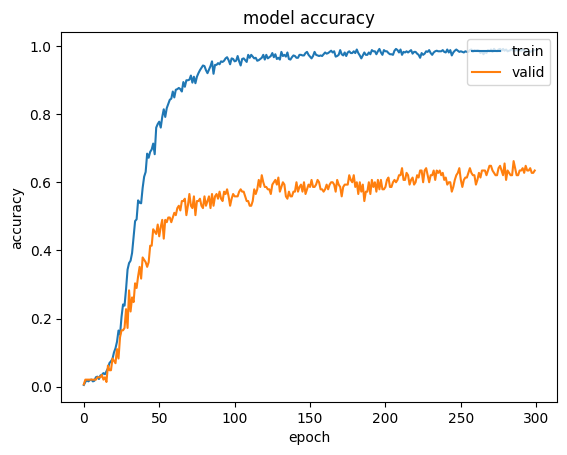

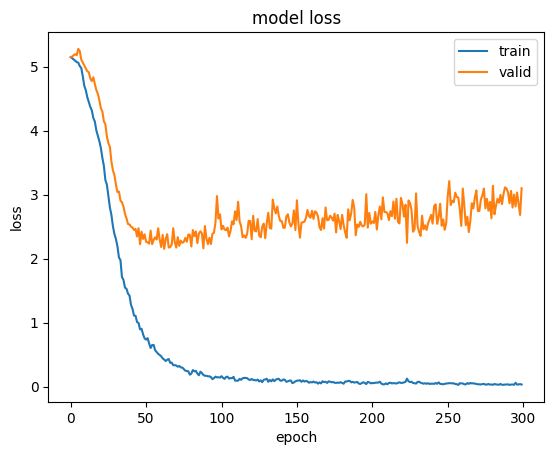

In [12]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')
plt.show()

In [13]:
from tensorflow.keras.models import load_model

# Menyimpan model
# model.save('chatbot-new-.h5')

# Memuat model dari file H5
loaded_model = load_model('best_model.h5')


In [14]:
import re
import string

# Load stopwords from file
stop_words = set()
with open('stopword_id.txt', 'r', encoding='utf-8') as file:
    for line in file:
        stop_words.add(line.strip())


# Normalization rule for replacing "haid" with "menstruasi"
normalization_rules = {'haid': 'menstruasi'}

def preprocess_input(user_input):
    # Convert to lowercase
    user_input = user_input.lower()

    # Normalize using rules
    for key, value in normalization_rules.items():
        user_input = user_input.replace(key, value)

    # Remove characters not in [a-zA-Z0-9\s]
    user_input = re.sub(r'[.,’"\'-?:!;]', '', user_input)

    # Remove punctuation
    user_input = user_input.translate(str.maketrans("", "", string.punctuation))

    # Remove stopwords
    words = user_input.split()
    words = [word for word in words if word not in stop_words]

    # Join the words
    preprocessed_text = ' '.join(words)

    # Remove extra whitespaces
    preprocessed_text = re.sub(' +', ' ', preprocessed_text)

    return preprocessed_text

### check output

In [15]:
import random


while True:
    user_input = input('You: ')
    preprocessed_text = preprocess_input(user_input)
    # preprocessed_text = user_input
    print(preprocessed_text)
    if preprocessed_text.lower() == 'goodbye':
        print("Chatbot: Goodbye!")
        break
    try:
        input_seq = tokenizer.texts_to_sequences([preprocessed_text])
        input_seq = pad_sequences(input_seq, maxlen=max_len)
        predicted_label_seq = model.predict(input_seq)
        predicted_label = label_encoder.inverse_transform([predicted_label_seq.argmax(axis=-1)])[0]
        print("tags:", predicted_label)

        # Pilih respons dari kategori tag
        responses_for_tag = responses.get(predicted_label, ["Chatbot: Maaf, saya tidak memahami maksud Anda."])
        response = random.choice(responses_for_tag)

        print("Chatbot:", response)
    except:
        print("Chatbot: Maaf, saya tidak memahami maksud Anda.")


You: hi
hi
1/1 [==============================] - 1s 571ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


tags: salam
Chatbot: Hai! femibot di sini. Mau tau informasi tentang apa nih?


KeyboardInterrupt: ignored

In [16]:
# Instalasi tensorflowjs
!pip install tensorflowjs

# Impor modul yang diperlukan
from tensorflow.keras.models import load_model
import tensorflowjs as tfjs

# Muat model Keras
model_path = '/content/best_model.h5'
model = load_model(model_path)

# Konversi model ke format TensorFlow.js
tfjs.converters.save_keras_model(model, '/content/tfjs_model')


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
